# Boilerplate

Packae installation, loading, and dataloaders. There's also a simple model defined. You can change it your favourite architecture if you want.

In [1]:
!pip install tensorboardX

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time

from torchvision import datasets, transforms
from tensorboardX import SummaryWriter
from tqdm.notebook import tqdm

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

np.random.seed(42)
torch.manual_seed(42)


## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Simple NN. You can change this if you want.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081

# Add the data normalization as a first "layer" to the network
# this allows us to search for adverserial examples to the real image, rather than
# to the normalized image
model = nn.Sequential(Normalize(), Net())

model = model.to(device)
model.train()

Sequential(
  (0): Normalize()
  (1): Net(
    (fc): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=10, bias=True)
  )
)

# Implement the Attacks

Functions are given a simple useful signature that you can start with. Feel free to extend the signature as you see fit.

You may find it useful to create a 'batched' version of PGD that you can use to create the adversarial attack.

In [2]:
# The last argument 'targeted' can be used to toggle between a targeted and untargeted attack.
def fgsm(model, features, labels, eps, targeted=False):
    model.train()
    if targeted:
        features.requires_grad_() # this is required so we can compute the gradient w.r.t x
        eps = eps - 1e-7 # small constant to offset floating-point erros
        targeted_classes = (labels + 1) % 10
        L = nn.CrossEntropyLoss()
        loss = L(model(features), targeted_classes)
        loss.backward()
        grad = features.grad.data
        adv_features = features - eps * grad.sign()
        return adv_features
    else:
        features.requires_grad_() # this is required so we can compute the gradient w.r.t x
        eps = eps - 1e-7 # small constant to offset floating-point erros
        L = nn.CrossEntropyLoss()
        loss = L(model(features), labels)
        loss.backward()
        grad = features.grad.data
        adv_features = features + eps * grad.sign()
        return adv_features

def pgd_untargeted(model, x, labels, num_steps, eps_step, eps, clamp=(0,1)):
    model.train()
    x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    for _ in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        prediction = model(_x_adv)
        L = nn.CrossEntropyLoss()
        loss = L(prediction, labels)
        loss.backward()

        with torch.no_grad():
            gradients = _x_adv.grad.sign() * eps_step
            x_adv += gradients
        x_adv = torch.clamp(x_adv, x - eps, x + eps)
        x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()


# Implement Adversarial Training

In [3]:
def train_model(model, num_epochs, enable_defense=True):
    model.train()
    learning_rate = 0.0001

    opt = optim.Adam(params=model.parameters(), lr=learning_rate)

    ce_loss = torch.nn.CrossEntropyLoss()

    tot_steps = 0

    for epoch in tqdm(range(1,num_epochs+1)):
        t1 = time.time()
        for batch_idx, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc='epoch %d'%epoch)):

            if enable_defense:
                x_batch = pgd_untargeted(model, x_batch, y_batch, 10, 0.01, 0.3)

            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            tot_steps += 1
            opt.zero_grad()
            out = model(x_batch)
            batch_loss = ce_loss(out, y_batch)
            batch_loss.backward()
            opt.step()

        tot_test, tot_acc = 0.0, 0.0
        for batch_idx, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            tot_acc += acc
            tot_test += x_batch.size()[0]
        t2 = time.time()

        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch, tot_acc/tot_test, t2-t1))

In [4]:
train_model(model, 5, enable_defense=False)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1: Accuracy 0.91910 [25.57 seconds]


epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2: Accuracy 0.93620 [13.05 seconds]


epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3: Accuracy 0.94740 [13.31 seconds]


epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4: Accuracy 0.95490 [13.07 seconds]


epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5: Accuracy 0.95820 [13.04 seconds]


# Study Accuracy, Quality, etc.

Compare the various results and report your observations on the submission.

In [5]:
# Your code here

In [6]:
def record_accuracy(model, data_loader, attack=None):
    correct = 0
    total = 0
    for features, labels in data_loader:
        features = features.to(device)
        labels = labels.to(device)
        if attack is not None:
            features = attack(model, features, labels)
        model.eval()
        output = model(features)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += len(features)
    return correct / total

In [7]:
acc = record_accuracy(model, test_loader)
print("The original model accuracy is: {}".format(acc))

The original model accuracy is: 0.9582


In [8]:
fgsm_untargeted = lambda model, x, y: fgsm(model, x, y, 0.1, False)
fgsm_acc = record_accuracy(model, test_loader, fgsm_untargeted)
print("The accuracy on untargeted FGSM examples is: {}".format(fgsm_acc))

The accuracy on untargeted FGSM examples is: 0.0424


In [9]:
fgsm_targeted = lambda model, x, y: fgsm(model, x, y, 0.1, True)
fgsm_acc = record_accuracy(model, test_loader, fgsm_targeted)
print("The accuracy on targeted FGSM examples is: {}".format(fgsm_acc))

The accuracy on targeted FGSM examples is: 0.1722


In [10]:
pgd = lambda model, x, y: pgd_untargeted(model, x, y, 10, 0.01, 0.1)
pgd_acc = record_accuracy(model, test_loader, pgd)
print("The accuracy on untargeted PGD examples is: {}".format(pgd_acc))

The accuracy on untargeted PGD examples is: 0.2174


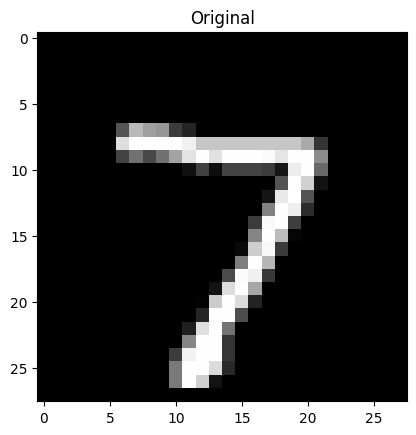

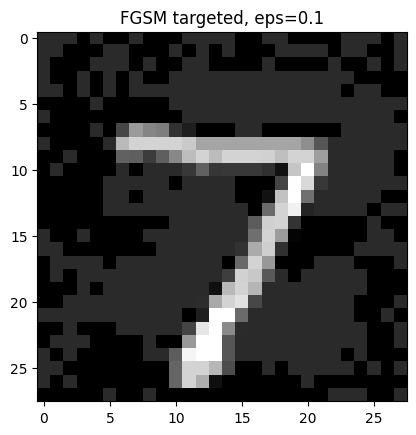

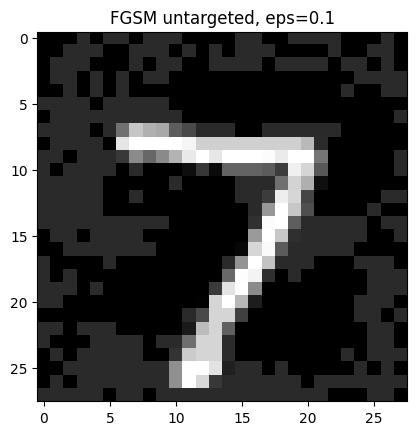

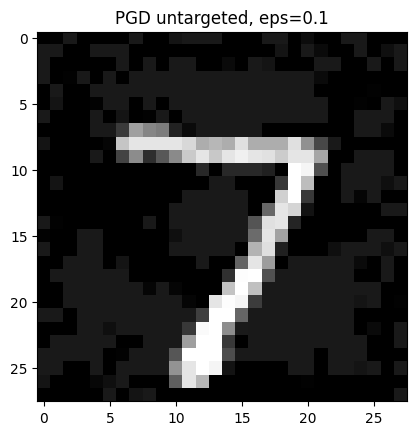

In [11]:
# visualize the adverserial example and the original image
import matplotlib.pyplot as plt
test_features, test_labels = next(iter(test_loader))
fgsm_targeted_features = fgsm(model, test_features, test_labels, 0.1, True)
fgsm_untargeted_features = fgsm(model, test_features, test_labels, 0.1, False)
pgd_features = pgd_untargeted(model, test_features, test_labels, 10, 0.01, 0.1)
plt.imshow(test_features[0].cpu().detach().numpy().reshape(28,28), cmap='gray')
plt.title("Original")
plt.show()
plt.imshow(fgsm_targeted_features[0].cpu().detach().numpy().reshape(28,28), cmap='gray')
plt.title("FGSM targeted, eps=0.1")
plt.show()
plt.imshow(fgsm_untargeted_features[0].cpu().detach().numpy().reshape(28,28), cmap='gray')
plt.title("FGSM untargeted, eps=0.1")
plt.show()
plt.imshow(pgd_features[0].cpu().detach().numpy().reshape(28,28), cmap='gray')
plt.title("PGD untargeted, eps=0.1")
plt.show()

# Perform PGD-based adversarial training

In [12]:
train_model(model, 2, True)

  0%|          | 0/2 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1: Accuracy 0.95260 [38.77 seconds]


epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2: Accuracy 0.95850 [40.03 seconds]


In [13]:
pgd = lambda model, x, y: pgd_untargeted(model, x, y, 10, 0.01, 0.1)
pgd_acc = record_accuracy(model, test_loader, pgd)
print("The accuracy on PGD examples with a PGD-based adversarially trained model is: {}".format(pgd_acc))

The accuracy on PGD examples with a PGD-based adversarially trained model is: 0.7906


# Bonus

Apply FGSM on the PGD-based adversarially trained model

In [14]:
fgsm_untargeted = lambda model, x, y: fgsm(model, x, y, 0.1, False)
fgsm_acc = record_accuracy(model, test_loader, fgsm_untargeted)
print("The accuracy on untargeted FGSM examples with a PGD-based adversarially trained model is: {}".format(fgsm_acc))

The accuracy on untargeted FGSM examples with a PGD-based adversarially trained model is: 0.674


In [15]:
fgsm_targeted = lambda model, x, y: fgsm(model, x, y, 0.1, True)
fgsm_acc = record_accuracy(model, test_loader, fgsm_targeted)
print("The accuracy on targeted FGSM examples with a PGD-based adversarially trained model is: {}".format(fgsm_acc))

The accuracy on targeted FGSM examples with a PGD-based adversarially trained model is: 0.8529


In [16]:
acc = record_accuracy(model, test_loader)
print("The accuracy on natural examples with a PGD-based adversarially trained model is: {}".format(acc))

The accuracy on natural examples with a PGD-based adversarially trained model is: 0.9585


## Observation
- A PGD-based adversarially trained model also performs better when defensing against targeted/untargeted FGSM attacks.
- The performance of a PGD-based trained model is closely related to the choice of hyperparameters, such as the number of iterations and the step size. A PGD-based adversarially trained model could perform poorly on natural examples when trained with bad hyperparameters.